In [2]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [3]:
# set some constants for reproducibility

RANDOM_STATE = 42
N_THREADS = 4

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## 1. Загрузка данных

In [4]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/examples/data/sampled_app_train.csv'

In [5]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [6]:
TARGET_NAME = 'TARGET'

data = pd.read_csv('../data/sampled_app_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


Делим выборку на обучающую и тестовую

In [8]:
tr_data, te_data = train_test_split(
    data,
    test_size=0.2, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (8000, 122), te_data = (2000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
6444,112261,0,Cash loans,F,N,N,1,90000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
3586,115058,0,Cash loans,F,N,Y,0,180000.0,239850.0,23850.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9349,326623,0,Cash loans,F,N,Y,0,112500.0,337500.0,31086.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
7734,191976,0,Cash loans,M,Y,Y,1,67500.0,135000.0,9018.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2174,281519,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## 2. Обертка `ReportDeco` для `TabularAutoML`

In [ ]:
task = Task(
    'binary',  # required
    loss='logloss',
    metric='auc'
)

In [ ]:
# specify feature roles
roles = {
    'target': TARGET_NAME,  # required
    'drop': ['SK_ID_CURR']  # remove user's id
}

In [ ]:
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 600  # 10 minutes

In [ ]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

automl = TabularAutoML(
    task=task,  # required
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

automl_rd = RD(automl)

In [ ]:
%%time
oof_preds = automl_rd.fit_predict(tr_data, roles=roles, verbose=1)

[19:36:40] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:36:40] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[19:36:40] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[19:36:40] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:36:40] - time: 600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 600.00 seconds


[19:36:40] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:36:40] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:36:40] Train data shape: (8000, 122)



INFO:lightautoml.reader.base:Train data shape: (8000, 122)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:36:48] Layer 1 train process start. Time left 591.19 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 591.19 secs


[19:36:49] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183], 'embed_sizes': array([ 6,  6,  3,  9,  6,  3, 20,  8,  5,  3,  9, 10,  3,  6,  8,  3],
      dtype=int32), 'data_size': 184}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6797873534647273
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7013219579731761
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7193097807784209
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear

[19:36:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7354156182851765


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7354156182851765


[19:36:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:36:57] Time left 582.98 secs



INFO:lightautoml.automl.base:Time left 582.98 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.742082
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.751576
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.748197
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.749753
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[208]	valid's auc: 0.752009


[19:37:03] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:37:04] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 32, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.746829
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.74793
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.750004
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.750009
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	v

[19:38:08] Time limit exceeded after calculating fold 3



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 3



[19:38:08] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7330589819023094


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7330589819023094


[19:38:08] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:38:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e9c3585e-79f8-447e-82c7-0fd95259e812
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.737581
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.741697
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.743012
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.74306
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.743953
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.742777
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[467]	valid's auc: 0.744819
INFO:optuna.study.study:Trial 0 finished with value: 0.7448188121087715 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagg

[19:38:37] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7448 auc


[19:38:37] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.739516
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.73555
DEBUG:lightautoml.ml_algo.boost_lgbm:Early st

[19:39:15] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7082964207378947


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7082964207378947


[19:39:15] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:39:15] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 5000, 'learning_rate': 0.035, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5609875	best: 0.5609875 (0)	total: 56.2ms	remaining: 4m 41s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7415153	best: 0.7415153 (100)	total: 610ms	remaining: 29.6s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7273495	best: 0.7437390 (13

[19:39:28] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7174998549008127


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7174998549008127


[19:39:28] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:39:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 221.53 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 221.53 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-53c8c6c1-ad55-43a0-85da-b043e2c9f699
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5434995	best: 0.5434995 (0)	total: 5.1ms	remaining: 25.5s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7336840	best: 0.7342506 (99)	total: 458ms	remaining: 22.2s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.7393770	best: 0.7437657 (154)	total: 898ms	remaining: 21.4s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.743765736
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 154
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 155 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.7437657360039771 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002

[19:42:59] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.43692131736864614, 'min_data_in_leaf': 6}
 achieve 0.7695 auc


[19:42:59] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.43692131736864614, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 6, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5434995	best: 0.5434995 (0)	total: 6.39ms	remaining: 19.2s
DEBUG:lightautoml.ml_algo.boost_cb:100:	test: 0.7500788	best: 0.7500842 (96)	total: 455ms	remaining: 13.1s
DEBUG:lightautoml.ml_algo.boost_cb:200:	test: 0.754

[19:43:18] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7463309039583695


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.7463309039583695


[19:43:18] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:43:18] Time left 201.22 secs



INFO:lightautoml.automl.base:Time left 201.22 secs



[19:43:18] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



INFO:lightautoml.automl.base:Time limit exceeded in one of the tasks. AutoML will blend level 1 models.



[19:43:18] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:43:18] Blending: optimization starts with equal weights and score 0.7518305352044643


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.7518305352044643


[19:43:19] Blending: iteration 0: score = 0.7527091028107997, weights = [0.15691894 0.19175276 0.2685984  0.09242818 0.29030165]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.7527091028107997, weights = [0.15691894 0.19175276 0.2685984  0.09242818 0.29030165]


[19:43:19] Blending: iteration 1: score = 0.7527197327878878, weights = [0.162059   0.19803382 0.24464057 0.09545576 0.2998108 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.7527197327878878, weights = [0.162059   0.19803382 0.24464057 0.09545576 0.2998108 ]


[19:43:19] Blending: iteration 2: score = 0.7527341895567279, weights = [0.1698744  0.17972904 0.23606798 0.10005917 0.3142694 ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.7527341895567279, weights = [0.1698744  0.17972904 0.23606798 0.10005917 0.3142694 ]


[19:43:19] Blending: iteration 3: score = 0.7527341895567279, weights = [0.1698744  0.17972904 0.23606798 0.10005917 0.3142694 ]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = 0.7527341895567279, weights = [0.1698744  0.17972904 0.23606798 0.10005917 0.3142694 ]


[19:43:19] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[19:43:19] Automl preset training completed in 399.41 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 399.41 seconds



[19:43:19] Model description:
Final prediction for new objects (level 0) = 
	 0.16987 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.17973 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.23607 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.10006 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31427 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.16987 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.17973 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.23607 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.10006 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31427 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



CPU times: user 9min 56s, sys: 36.2 s, total: 10min 33s
Wall time: 6min 44s


In [ ]:
%%time

te_preds = automl_rd.predict(te_data)
print(f'Prediction for te_data:\n{te_preds}\nShape = {te_preds.shape}')

Prediction for te_data:
array([[0.05017056],
       [0.05931688],
       [0.02573707],
       ...,
       [0.05060218],
       [0.03328998],
       [0.18678895]], dtype=float32)
Shape = (2000, 1)
CPU times: user 4.46 s, sys: 127 ms, total: 4.58 s
Wall time: 4.61 s


In [ ]:
print(f'OOF score: {roc_auc_score(tr_data[TARGET_NAME].values, oof_preds.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(te_data[TARGET_NAME].values, te_preds.data[:, 0])}')

OOF score: 0.7527392919457302
HOLDOUT score: 0.7326936141304348


### Feature importance

**'fast'**: Считает важность на основе параметров обученной модели.

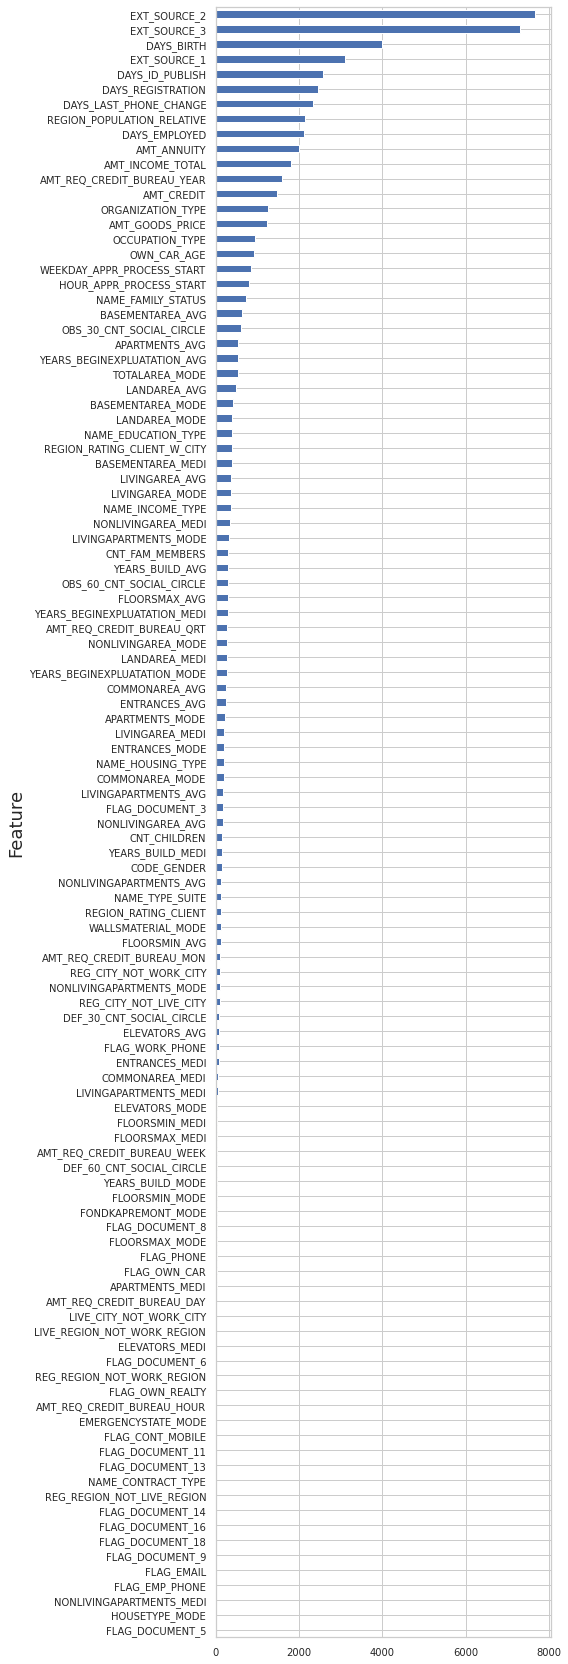

CPU times: user 1.45 s, sys: 167 ms, total: 1.62 s
Wall time: 1.6 s


In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()

**'accurate'**: Считает Permutation Importance для каждого признака, замеряя качество на отложенной выборке.

In [ ]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', te_data, silent=False)

INFO3:lightautoml.automl.presets.utils:LightAutoML ts master used 109 feats
INFO3:lightautoml.automl.presets.utils:1/109 Calculated score for CODE_GENDER: 0.0044090
INFO3:lightautoml.automl.presets.utils:2/109 Calculated score for FLOORSMAX_MEDI: 0.0012602
INFO3:lightautoml.automl.presets.utils:3/109 Calculated score for FLAG_EMP_PHONE: -0.0000781
INFO3:lightautoml.automl.presets.utils:4/109 Calculated score for COMMONAREA_MODE: -0.0021875
INFO3:lightautoml.automl.presets.utils:5/109 Calculated score for LIVE_REGION_NOT_WORK_REGION: 0.0003227
INFO3:lightautoml.automl.presets.utils:6/109 Calculated score for WALLSMATERIAL_MODE: -0.0005605
INFO3:lightautoml.automl.presets.utils:7/109 Calculated score for NONLIVINGAPARTMENTS_AVG: -0.0000577
INFO3:lightautoml.automl.presets.utils:8/109 Calculated score for AMT_REQ_CREDIT_BUREAU_MON: -0.0004212
INFO3:lightautoml.automl.presets.utils:9/109 Calculated score for TOTALAREA_MODE: 0.0008118
INFO3:lightautoml.automl.presets.utils:10/109 Calculated

CPU times: user 4min, sys: 2.76 s, total: 4min 3s
Wall time: 3min 9s


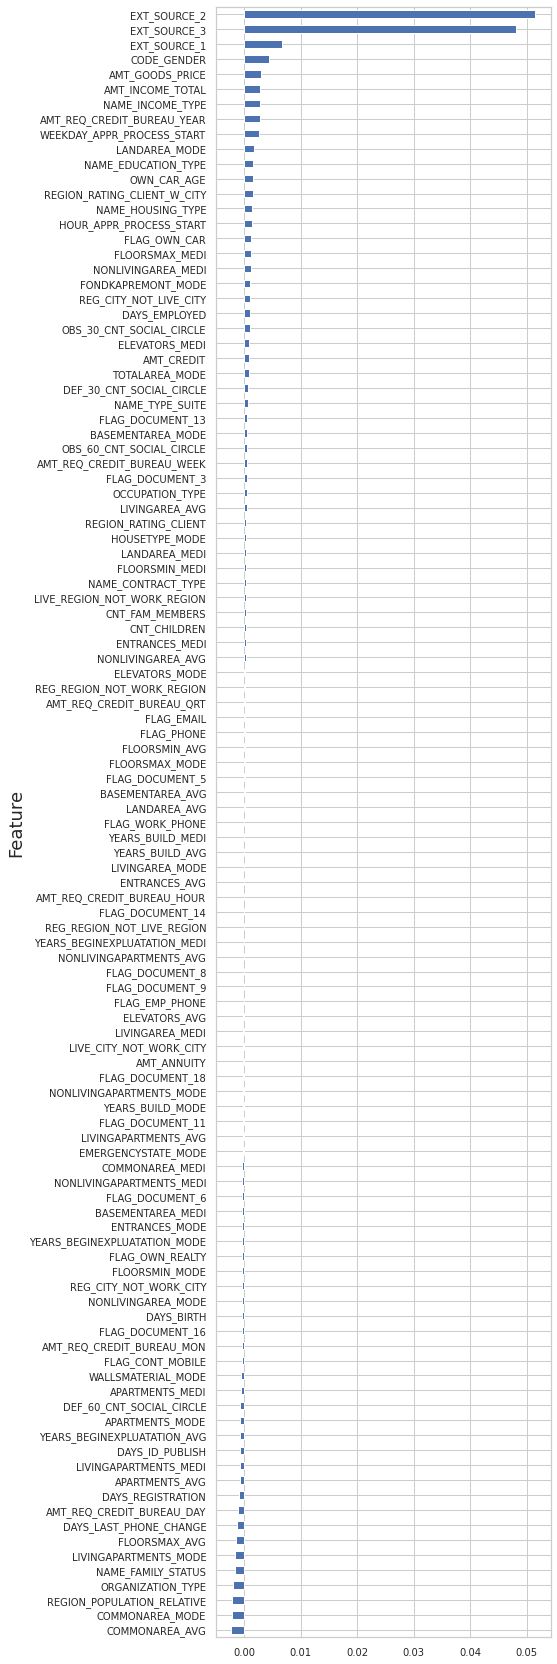

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.barh(figsize=(6, 30), grid=True, rot=0)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.gca().invert_yaxis()
plt.show()